In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import cv2
import time
import gc
from keras.utils import np_utils
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import matplotlib.pyplot as plt
from keras.layers import concatenate
import random
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
#from google.colab import files


Using TensorFlow backend.


## Preprocessing

In [0]:
def invert(img):
    return 255-img


def datasets(data_path):
    train_path = join(data_path,'TrainingSet')
    train = {}
    onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]
    for i in onlyfiles:
        train[i]=invert(cv2.imread(join(train_path, i),0)).reshape((64,64,1))
    
    val_path = join(data_path,'ValidationSet')
    val = {}
    onlyfiles = [f for f in listdir(val_path) if isfile(join(val_path, f))]
    for i in onlyfiles:
        val[i]=invert(cv2.imread(join(val_path, i),0)).reshape((64,64,1))
    
    train_pairs = pd.read_csv(join(data_path,'dataset_seen_training_siamese.csv'),index_col=0)
    train_pairs['left'] = train_pairs['left'].apply(lambda x:train[x])
    train_pairs['right'] = train_pairs['right'].apply(lambda x:train[x])
    #train_imgs = pd.DataFrame.from_dict(train, orient='index')

    
    val_pairs = pd.read_csv(join(data_path,'dataset_seen_validation_siamese.csv'),index_col=0)
    val_pairs['left'] = val_pairs['left'].apply(lambda x:val[x])
    val_pairs['right'] = val_pairs['right'].apply(lambda x:val[x])
    #val_imgs = pd.DataFrame.from_dict(val, orient='index')
    

    
    return {"train_left":train_pairs['left'],"train_right":train_pairs['right'],"train_target":train_pairs['label'],"train_imgs":train,
            "val_left":val_pairs['left'],"val_right":val_pairs['right'],"val_target":val_pairs['label'],"val_imgs":val}

In [0]:
seen_dataset = datasets("../seen-dataset")
shuffled_dataset = datasets("../shuffled-dataset")
unseen_dataset = datasets("../unseen-dataset")

# Code to import data from pickle for google colab

In [0]:
'''
import pickle
with open('../seen_dataset.pickle', 'wb') as f:
    pickle.dump(seen_dataset,f)
with open('../unseen_dataset.pickle', 'wb') as f:
    pickle.dump(unseen_dataset,f)
with open('../shuffled_dataset.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(shuffled_dataset,f)
'''

import pickle


with open('../seen_dataset.pickle', 'rb') as f:
    seen_dataset = pickle.load(f)
with open('../unseen_dataset.pickle', 'rb') as f:
    unseen_dataset = pickle.load(f)
with open('../shuffled_dataset.pickle', 'rb') as f:
    shuffled_dataset = pickle.load(f)


## Neural Network

In [0]:
from keras.models import Model
from keras.layers import Input,Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Flatten
from IPython.display import SVG,Image
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
import keras

# Siamese

In [4]:
imDim = 64
input_shape  = (imDim,imDim,1)
inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
model = inp_img


model = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(model)

model = MaxPooling2D((2,2), padding='valid')(model)
model = Conv2D(64, (3, 3), activation='relu',padding='valid')(model)

model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(128, (3, 3), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)


model = Conv2D(256, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)

model = Flatten()(model)

feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
feat.summary()




left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
right_img = Input(shape = (imDim,imDim,1), name = 'right_img')


# In[28]:

left_feats = feat(left_img)
right_feats = feat(right_img)


# In[35]:



tb_batch_size = 64
early_patience = 10
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
# Earlystopping is used to stop training epochs when specified monitored parameter stops improving 
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')


merged_feats = concatenate([left_feats, right_feats], name = 'concat_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(1, activation = 'sigmoid')(merged_feats)
similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
similarity_model.summary()
optimizer = Adam(lr = 0.0006)
similarity_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_

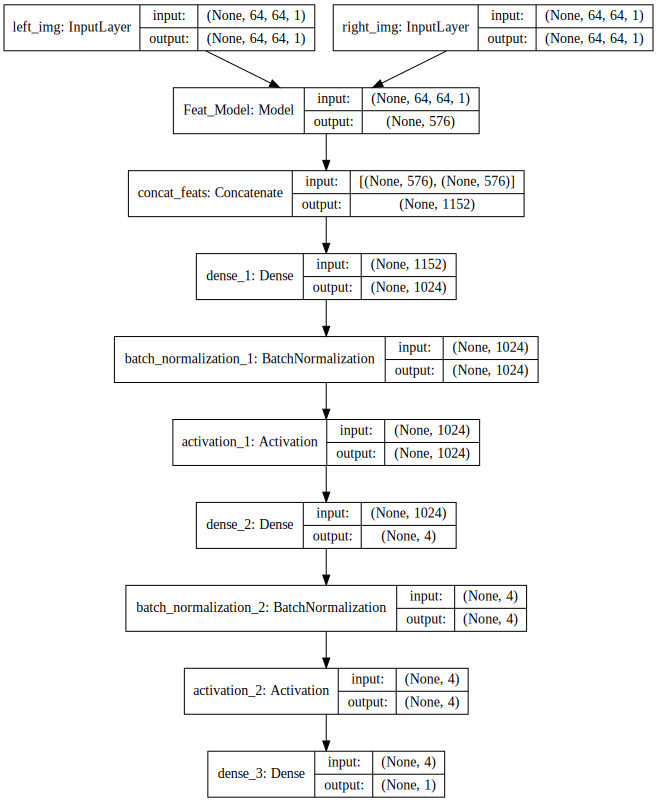

In [21]:
SVG(model_to_dot(similarity_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Batch generator

In [0]:
def generator(left,right, labels, batch_size):
    index = np.random.permutation(len(left))
    batch_right = np.zeros((batch_size, 64, 64, 1))
    batch_left = np.zeros((batch_size, 64, 64, 1))
    batch_labels = np.zeros((batch_size))
    counter = 0
    while True:
        
         # choose random index in features
        if counter+batch_size<=len(left):
            batch_left = conv(left.iloc[index[counter:counter+batch_size]])
            batch_right = conv(right.iloc[index[counter:counter+batch_size]])
            batch_labels = np.array(labels.iloc[index[counter:counter+batch_size]])
            counter+=batch_size
            #print(counter)
            yield [batch_left.astype('float32') / 255.,batch_right.astype('float32') / 255.], batch_labels
        else:
            yield [conv(left.iloc[counter:]).astype('float32') / 255.,conv(right.iloc[counter:]).astype('float32') / 255.],labels[counter:]

In [0]:
def conv(col):
    tmp = np.empty((len(col),64,64,1))
  
    for i in range(len(col)):
        tmp[i]=col.iloc[i]
    return tmp

def convert(dic):
    dic['val_left'] = conv(dic['val_left']).astype('float32') / 255.
    dic['val_right'] = conv(dic['val_right']).astype('float32') / 255.
    dic['val_target'] = np.array(dic['val_target'])
    return dic

In [0]:

seen_dataset = convert(seen_dataset)

unseen_dataset = convert(unseen_dataset)

shuffled_dataset = convert(shuffled_dataset)


In [0]:
def train(dataset,optimizer = Adam(lr = 0.0006)):
    imDim = 64
    input_shape  = (imDim,imDim,1)
    inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
    model = inp_img


    model = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(model)

    model = MaxPooling2D((2,2), padding='valid')(model)
    model = Conv2D(64, (3, 3), activation='relu',padding='valid')(model)

    model = MaxPooling2D((2,2),padding='valid')(model)

    model = Conv2D(128, (3, 3), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)


    model = Conv2D(256, (1, 1), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)

    model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)

    model = Flatten()(model)

    feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')





    left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
    right_img = Input(shape = (imDim,imDim,1), name = 'right_img')


# In[28]:

    left_feats = feat(left_img)
    right_feats = feat(right_img)


# In[35]:


    tb_batch_size = 64
    early_patience = 10
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
# Earlystopping is used to stop training epochs when specified monitored parameter stops improving 
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')


    merged_feats = concatenate([left_feats, right_feats], name = 'concat_feats')
    merged_feats = Dense(1024, activation = 'linear')(merged_feats)
    merged_feats = BatchNormalization()(merged_feats)
    merged_feats = Activation('relu')(merged_feats)
    merged_feats = Dense(4, activation = 'linear')(merged_feats)
    merged_feats = BatchNormalization()(merged_feats)
    merged_feats = Activation('relu')(merged_feats)
    merged_feats = Dense(1, activation = 'sigmoid')(merged_feats)
    similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
    similarity_model.summary()
    similarity_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
    runtime = time.time()
    batch_size = 64
    history = similarity_model.fit_generator(generator(dataset['train_left'],dataset['train_right'],dataset['train_target'],batch_size=batch_size),
                                epochs=500,
                                verbose=1,
                                shuffle=True,
                                steps_per_epoch = 1,
                                validation_data=([dataset['val_left'],dataset['val_right']],dataset['val_target']),
                                callbacks = [tensorboard_cb])
    runtime = time.time()-runtime
    %matplotlib inline
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))
    print("Runtime : %f s"%runtime)
    return similarity_model,history,runtime

Instructions for updating:
Colocations handled automatically by placer.


## Seen pairs training

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Feat_Model (Model)              (None, 576)          142144      left_img[0][0]                   
                                                                 right_img[0][0]                  
__________________________________________________________________________________________________
concat_feats (Concatenate)      (None, 1152)         0           Feat_Model[1][0]                 
          

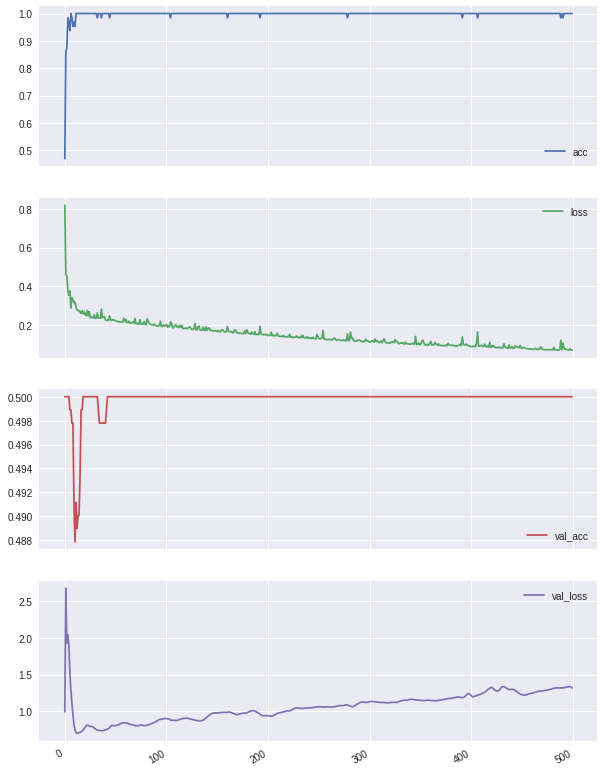

In [0]:
seen_training = train(seen_dataset)

## Unseen pairs training

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Feat_Model (Model)              (None, 576)          142144      left_img[0][0]                   
                                                                 right_img[0][0]                  
__________________________________________________________________________________________________
concat_feats (Concatenate)      (None, 1152)         0           Feat_Model[1][0]                 
          

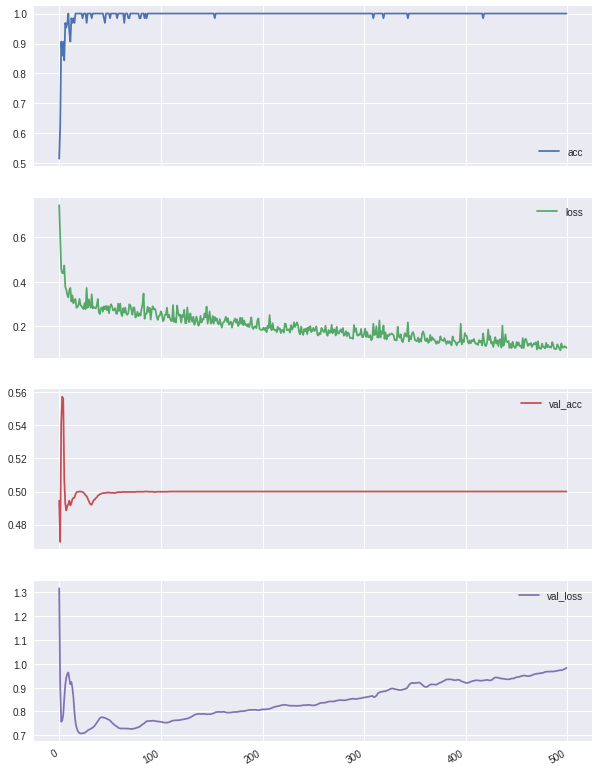

In [0]:
unseen_training = train(unseen_dataset)

## Shuffled pairs training

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Feat_Model (Model)              (None, 576)          142144      left_img[0][0]                   
                                                                 right_img[0][0]                  
__________________________________________________________________________________________________
concat_feats (Concatenate)      (None, 1152)         0           Feat_Model[1][0]                 
          

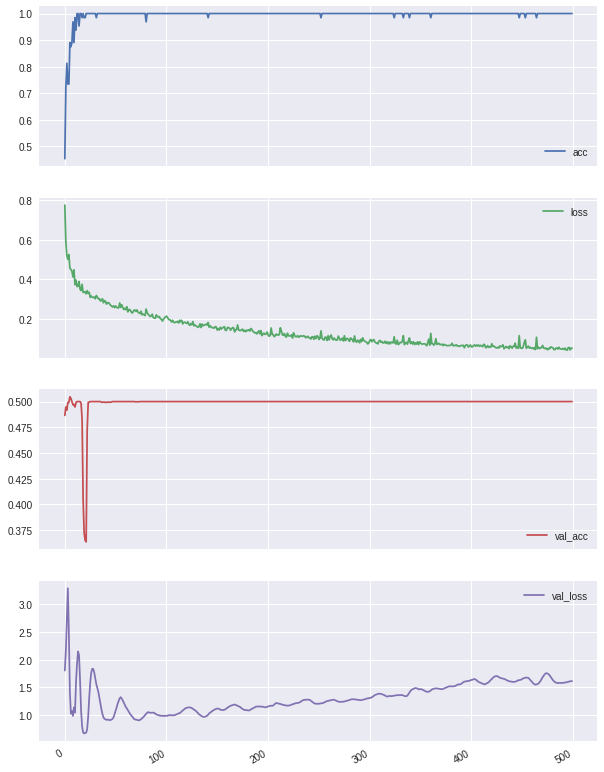

In [0]:
shuffled_training = train(shuffled_dataset)

# Autoencoder

In [9]:
input_img = Input(shape=(64, 64, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

encoder = Model(input_img,encoded)
encoder.summary()

latent_inputs = Input(shape=(512,))
r = Dense(8*8*8, activation='relu')(latent_inputs)
r = Reshape(target_shape=(8,8,8))(r)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

decoder = Model(latent_inputs,decoded)

decoder.summary()


output = decoder(encoder(input_img))
autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 64)          0         
__________

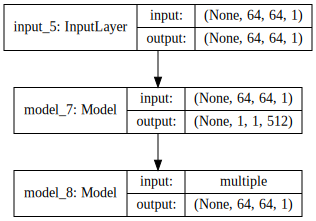

In [10]:
SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

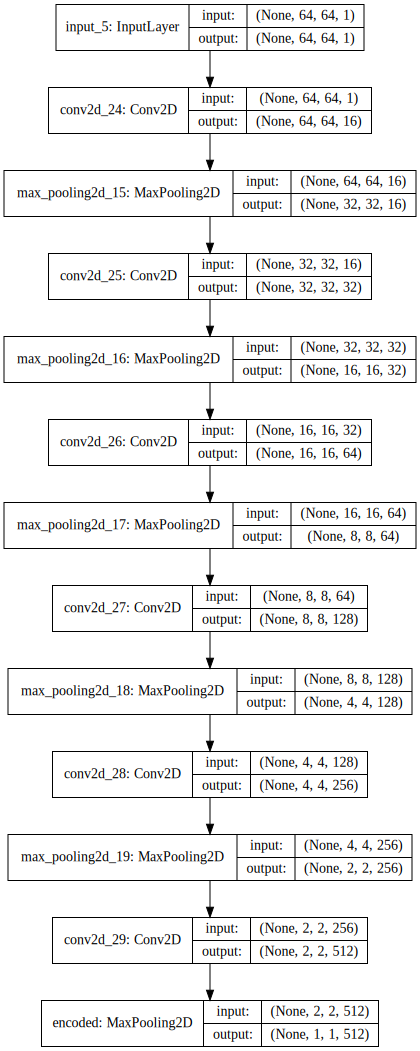

In [16]:
SVG(model_to_dot(encoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

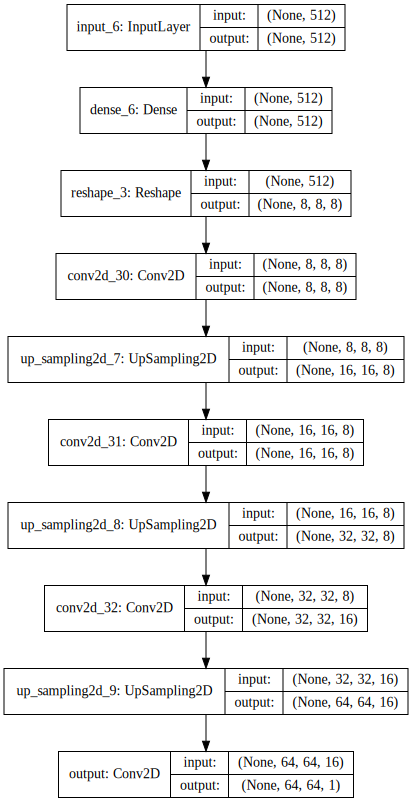

In [12]:
SVG(model_to_dot(decoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def cosine_accuracy(dataset,encoder,threshold=0.6):
    left = dataset['val_left']
    right = dataset['val_right']
    
    left_latent = encoder.predict(left/255.0)
    right_latent = encoder.predict(right/255.0)
    #display(left_latent.shape) , display(right_latent.shape)
    op = np.array([cosine_similarity(left_latent[i].reshape(-1,512), right_latent[i].reshape(-1,512))[0][0] for i in range(len(left))])
    op = (op-np.min(op))/(np.max(op)-np.min(op))

    index = np.where(op>threshold)
    pred = np.zeros(len(op))
    pred[index] = 1
    total = np.sum((pred==dataset['val_target']).astype(int))

    return total/len(left)

In [0]:
def shift(arr):
    for i in range(len(arr)):
        arr[i] = np.roll(arr[i],random.randint(-12,12),axis=0)
    return arr

def img_generator(data, batch_size):
    keys = [*data]
    index = np.random.permutation(len(keys))
    batch_data = np.zeros((batch_size, 64, 64, 1))
    batch_labels = np.zeros((batch_size, 64, 64, 1))
    counter = 0
    while True:
        if counter+batch_size<=len(keys):
            batch_index = index[counter:batch_size+counter]
            counter+=batch_size
            k=0
            for i in batch_index:
                batch_data[k] = data[keys[i]].astype('float32') /255.
                batch_labels[k] = data[keys[i]].astype('float32') /255.
                k+=1
            yield (batch_data), batch_labels
        else:
            batch_index = index[counter:]
            counter=0
            k=0
            for i in batch_index:
                batch_data[k] = data[keys[i]].astype('float32') /255.
                batch_labels[k] = data[keys[i]].astype('float32') /255.
                k+=1
            yield (batch_data[:k]), batch_labels[:k]
            
            
def img_generator_val(data):
    keys = [*data]
    batch_labels = np.zeros((len(data), 64, 64, 1))
    while True:
        for i in range(len(keys)):
            batch_labels[i] = data[keys[i]].astype('float32') /255.
        yield batch_labels, batch_labels

def custom_activation(x):
    return K.sigmoid(x)*255

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

        
def train_encoder(dataset,epochs=1000):
    input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
    # x = CoordinateChannel2D()(input_img)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # x = CoordinateChannel2D()(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # x = CoordinateChannel2D()(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten()(x)
    encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
    encoder = Model(input_img,encoded)

    r = Reshape(target_shape=(8,8,8))(encoded)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)


    tb_batch_size = 64

    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

    autoencoder = Model(input_img, decoded)

    autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])
    history = autoencoder.fit_generator(img_generator(dataset['train_imgs'],batch_size=32),
                                        epochs=epochs,
                                        verbose = 1,
                                        steps_per_epoch = 1,
                                        validation_data=img_generator_val(dataset['val_imgs']),
                                        validation_steps = 1,
                                        shuffle= True,
                                        callbacks = [tensorboard_cb])

    autoencoder.summary()

    historydf = pd.DataFrame(history.history)
    historydf.plot(subplots=True, grid=True, figsize=(10,15))

    n = 10 
    plt.figure(figsize=(24, 24))
    keys = [*seen_dataset['train_imgs']]
    dic = seen_dataset['train_imgs']

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dic[keys[i]].reshape((64,64)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n)
        #plt.imshow(autoencoder.predict((dic[keys[i]].astype('float64')).reshape((1,64,64,1))).reshape((64,64)))
        plt.imshow(255*autoencoder.predict((dic[keys[i]].astype('float64')/255.).reshape((1,64,64,1))).reshape((64,64)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return encoder, autoencoder

Instructions for updating:
Use tf.cast instead.
Epoch 1/3000
1/1 [==============================] - 4s 4s/step - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6885 - val_acc: 0.8392
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6885 - acc: 0.8436 - val_loss: 0.6823 - val_acc: 0.8815
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6826 - acc: 0.8856 - val_loss: 0.6730 - val_acc: 0.8864
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6730 - acc: 0.8882 - val_loss: 0.6596 - val_acc: 0.8880
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6594 - acc: 0.8880 - val_loss: 0.6408 - val_acc: 0.8887
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6404 - acc: 0.8887 - val_loss: 0.6148 - val_acc: 0.8892
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.6140 - acc: 0.8856 - val_loss: 0.5801 - val_acc: 0.8893
Epoch 8/3000
1/1 [==============================]

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


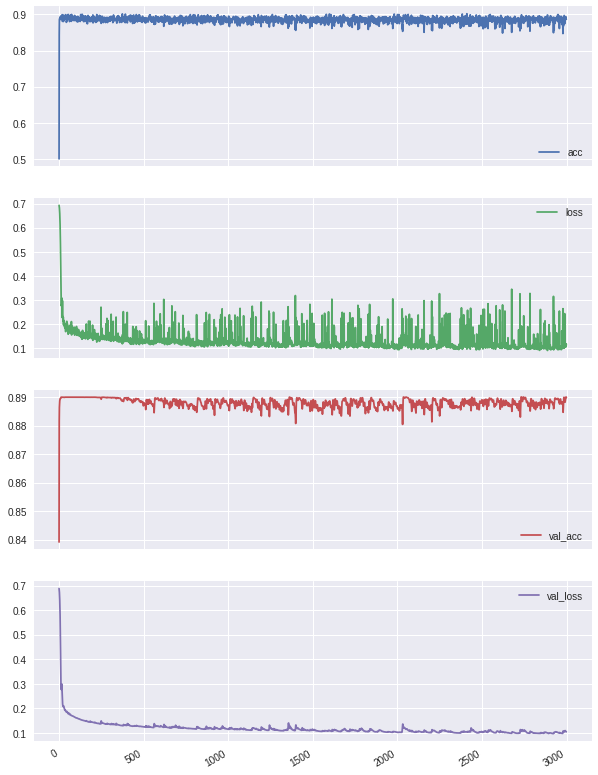

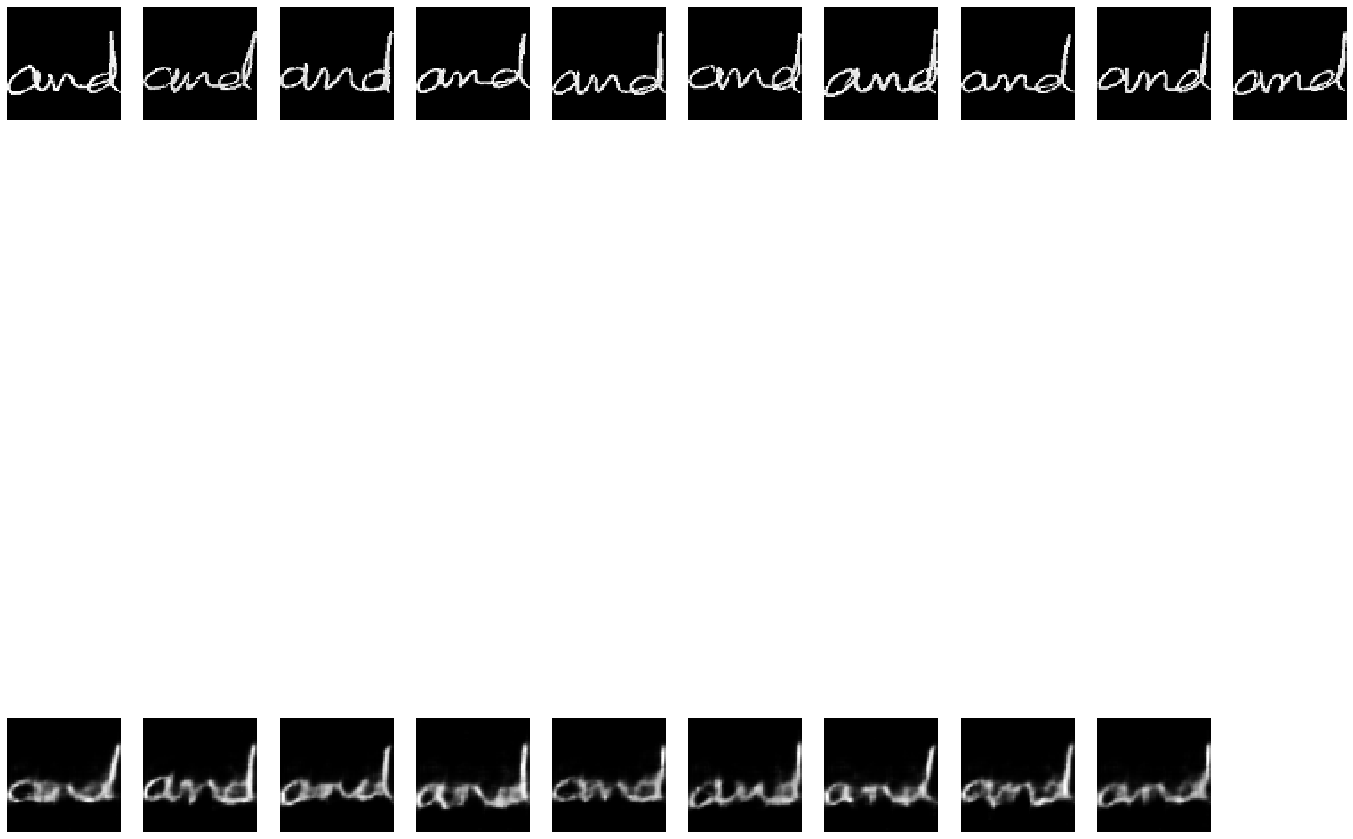

In [9]:
seen_encoder,seen_autoencoder = train_encoder(seen_dataset,epochs=3000)


In [0]:
"""
seen_encoder.save('seen_encoder.h5')
seen_autoencoder.save('seen_autoencoder.h5')
files.download('seen_encoder.h5')
files.download('seen_autoencoder.h5')
"""

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 0.6900 - acc: 0.8094 - val_loss: 0.6842 - val_acc: 0.8856
Epoch 2/5000
1/1 [==============================] - 2s 2s/step - loss: 0.6842 - acc: 0.8741 - val_loss: 0.6726 - val_acc: 0.8950
Epoch 3/5000
1/1 [==============================] - 2s 2s/step - loss: 0.6723 - acc: 0.8854 - val_loss: 0.6538 - val_acc: 0.8975
Epoch 4/5000
1/1 [==============================] - 2s 2s/step - loss: 0.6527 - acc: 0.8832 - val_loss: 0.6257 - val_acc: 0.8984
Epoch 5/5000
1/1 [==============================] - 2s 2s/step - loss: 0.6239 - acc: 0.8839 - val_loss: 0.5860 - val_acc: 0.8987
Epoch 6/5000
1/1 [==============================] - 2s 2s/step - loss: 0.5830 - acc: 0.8842 - val_loss: 0.5331 - val_acc: 0.8988
Epoch 7/5000
1/1 [==============================] - 2s 2s/step - loss: 0.5311 - acc: 0.8859 - val_loss: 0.4685 - val_acc: 0.8988
Epoch 8/5000
1/1 [==============================] - 2s 2s/step - loss: 0.4686 - acc: 0.8911 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


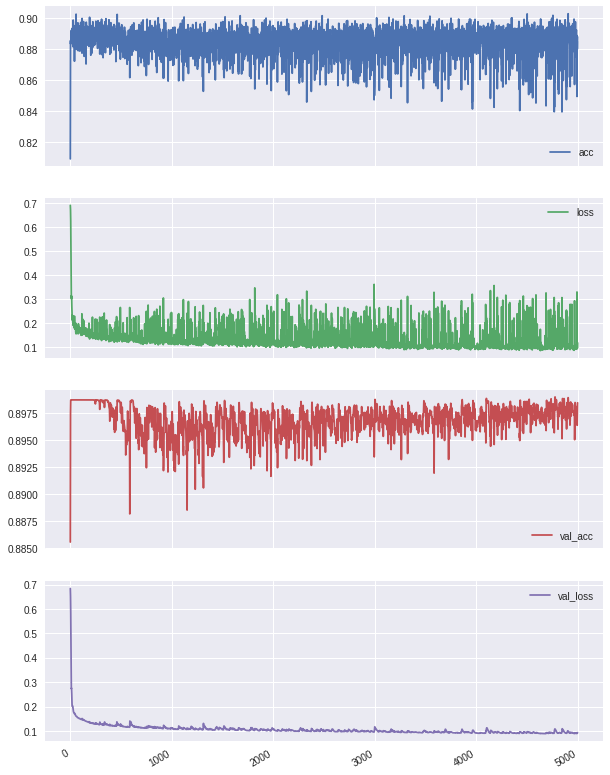

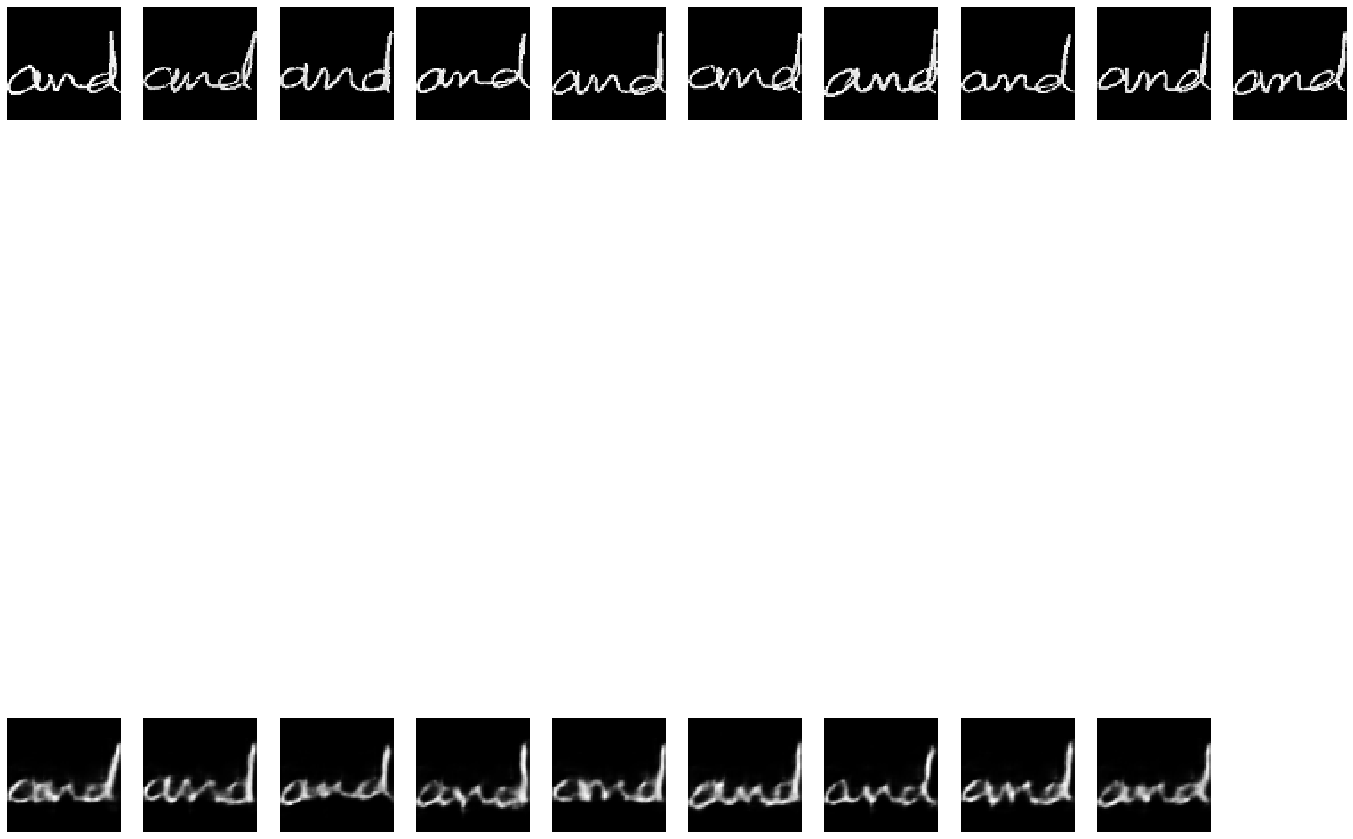

KeyboardInterrupt: ignored

In [77]:
unseen_encoder,unseen_autoencoder = train_encoder(unseen_dataset,epochs=5000)

In [0]:
'''
unseen_encoder.save('unseen_encoder.h5')
unseen_autoencoder.save('unseen_autoencoder.h5')
files.download('unseen_encoder.h5')
files.download('unseen_autoencoder.h5')
'''

Epoch 1/2000
1/1 [==============================] - 10s 10s/step - loss: 0.6930 - acc: 0.4502 - val_loss: 0.6905 - val_acc: 0.7473
Epoch 2/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6906 - acc: 0.7715 - val_loss: 0.6845 - val_acc: 0.8418
Epoch 3/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6850 - acc: 0.8631 - val_loss: 0.6759 - val_acc: 0.8607
Epoch 4/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6771 - acc: 0.8760 - val_loss: 0.6626 - val_acc: 0.8675
Epoch 5/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6657 - acc: 0.8998 - val_loss: 0.6429 - val_acc: 0.8697
Epoch 6/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6449 - acc: 0.8817 - val_loss: 0.6151 - val_acc: 0.8707
Epoch 7/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6181 - acc: 0.8825 - val_loss: 0.5759 - val_acc: 0.8713
Epoch 8/2000
1/1 [==============================] - 5s 5s/step - loss: 0.5819 - acc: 0.8902 - v

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


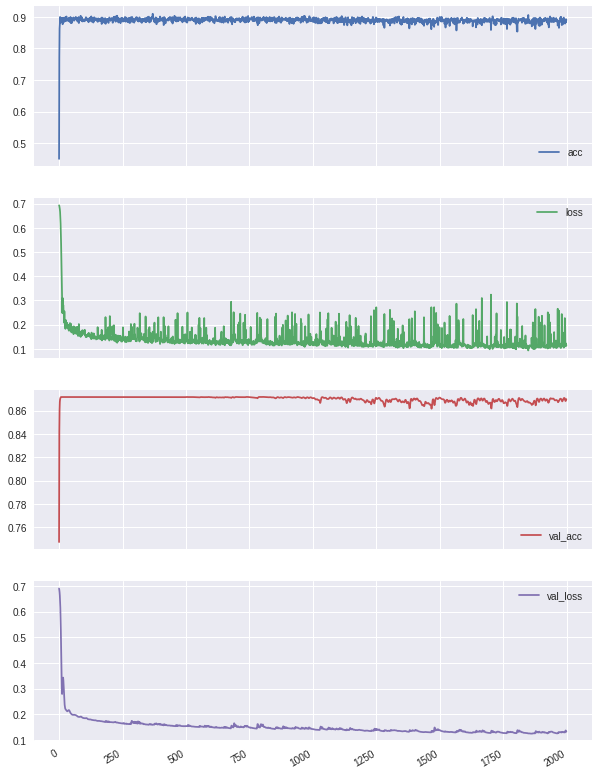

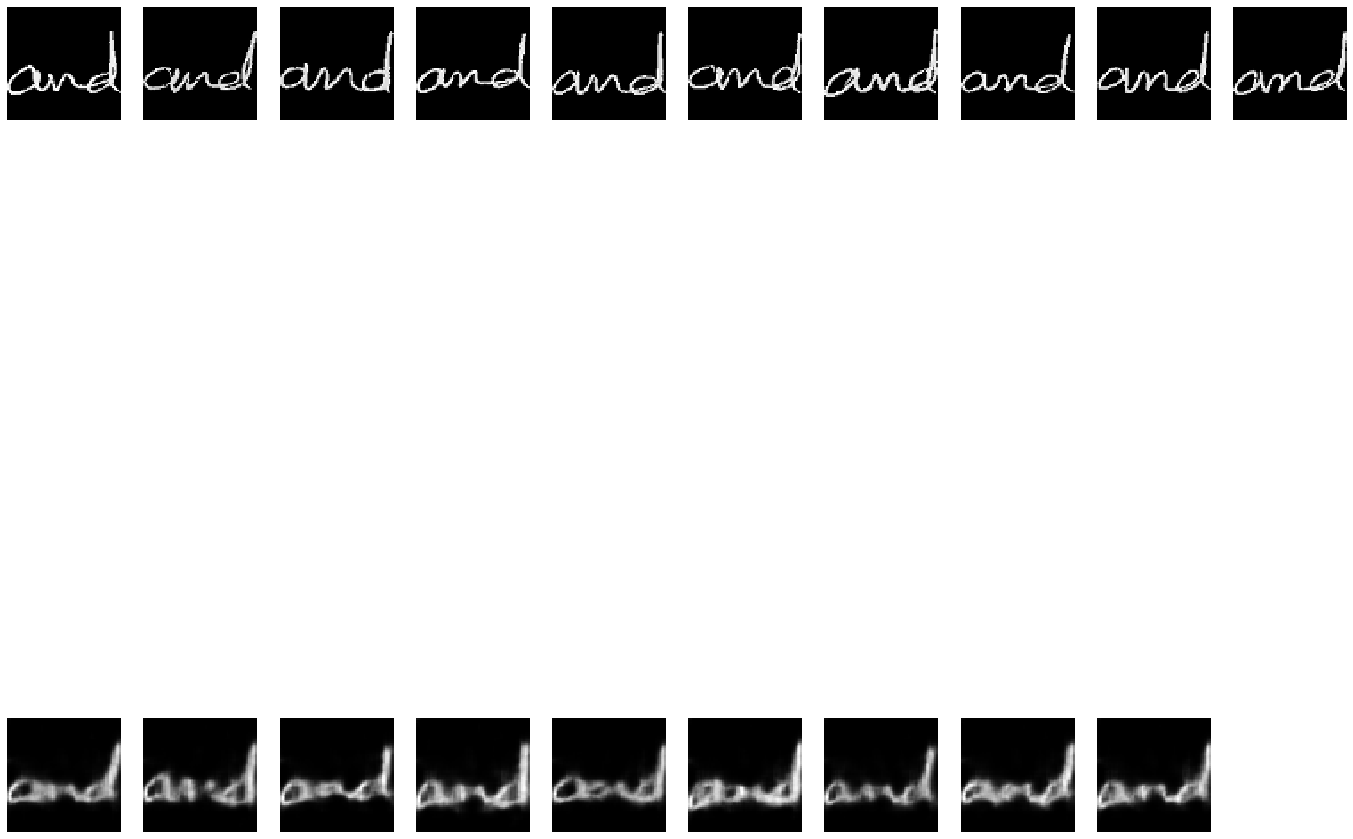

In [82]:
shuffled_encoder,shuffled_autoencoder = train_encoder(shuffled_dataset,epochs = 2000)

In [0]:
'''
shuffled_encoder.save('shuffled_encoder.h5')
shuffled_autoencoder.save('shuffled_autoencoder.h5')
files.download('shuffled_encoder.h5')
files.download('shuffled_autoencoder.h5')
'''

# Accuracy using seen-encoder

In [75]:
cosine_accuracy(seen_dataset,seen_encoder)

0.869757174392936

In [76]:
cosine_accuracy(shuffled_dataset,seen_encoder)

0.6925113464447806

In [80]:
cosine_accuracy(unseen_dataset,seen_encoder)

0.61688654353562

# Accuracy using unseen-encoder

In [85]:
cosine_accuracy(seen_dataset,unseen_encoder)

0.782560706401766

In [87]:
cosine_accuracy(shuffled_dataset,unseen_encoder)

0.504160363086233

In [86]:
cosine_accuracy(unseen_dataset,unseen_encoder)

0.5032981530343008

# Accuracy using shuffled-encoder

In [88]:
cosine_accuracy(seen_dataset,shuffled_encoder)

0.6854304635761589

In [90]:
cosine_accuracy(shuffled_dataset,shuffled_encoder)

0.550302571860817

In [89]:
cosine_accuracy(unseen_dataset,shuffled_encoder)

0.5523746701846965